<a href="https://colab.research.google.com/github/Palaeoprot/PalaeoProtCourse/blob/main/Tartu_Excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paleoproteomics Data Analysis Workflow

This notebook is designed for the Paleoproteomics Course (March 17-21, 2025) to help you understand how to process and analyze mass spectrometry data from NovorCloud. Each section is explained to help you understand the purpose of the code and how it works.


## Mount Google Drive
This section mounts your Google Drive to access files stored there. This is necessary because we'll be working with data files from NovorCloud that are stored in Google Drive.


In [1]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting Up the Environment
This section imports all the required libraries for our analysis. We'll use several Python libraries:
- Standard libraries for file handling, regular expressions, and data structures
- NumPy and Pandas for data manipulation
- Matplotlib and Seaborn for data visualization

In [2]:
# Standard library imports
import os
import re
import json
import zipfile
from collections import Counter
import glob

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## File Extraction and Organization
This section identifies and extracts data from zip files that were downloaded from NovorCloud. The code:
1. Looks for all zip files in the specified directory
2. Creates an output directory for extracted files if it doesn't exist
3. Extracts two types of files: parameters.js (search settings) and .peps.txt (peptide identifications)
4. Parses the filenames to extract metadata (student, sample, conditions)
5. Creates dataframes to track the extracted files and their metadata
6. Saves this metadata to CSV files for reference

In [14]:
import os
import zipfile
import re
import json
import pandas as pd
from glob import glob

# Define paths
zip_files_dir = '/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/NovorCloud Output'  # Path to where your zip files are
extracted_dir = '/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files'  # Path where you want to extract files
output_csv = '/content/combined_peptides_parameters.csv'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# First, extract all the zip files
zip_files = [f for f in os.listdir(zip_files_dir) if f.endswith('.zip')]
print(f"Found {len(zip_files)} zip files to extract")

for zip_file in zip_files:
    zip_path = os.path.join(zip_files_dir, zip_file)
    print(f"Extracting: {zip_file}")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Create a folder for each zip file to keep organization
            zip_extract_folder = os.path.join(extracted_dir, os.path.splitext(zip_file)[0])
            os.makedirs(zip_extract_folder, exist_ok=True)

            # Extract all files
            zip_ref.extractall(zip_extract_folder)
            print(f"  Successfully extracted to {zip_extract_folder}")
    except Exception as e:
        print(f"  ERROR extracting {zip_file}: {str(e)}")

# Now perform the recursive search for extracted files
all_peps_files = []
all_params_files = []

# Walk through all subdirectories in the extracted directory
for root, dirs, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith('.peps.txt'):
            all_peps_files.append(os.path.join(root, file))
        elif file.endswith('parameters.js'):
            all_params_files.append(os.path.join(root, file))

print(f"Found {len(all_peps_files)} peptide files and {len(all_params_files)} parameter files")

# If we didn't find any files, show directory contents for debugging
if len(all_peps_files) == 0 and len(all_params_files) == 0:
    print("\nNo files found. Debugging directory structure:")
    all_files = []
    for root, dirs, files in os.walk(extracted_dir):
        rel_path = os.path.relpath(root, extracted_dir)
        print(f"\nDirectory: {rel_path}")
        if files:
            print("  Files:")
            for file in files:
                print(f"    - {file}")
                all_files.append(os.path.join(root, file))

    print(f"\nTotal files found: {len(all_files)}")

    # Check if we need to look for different file extensions
    if len(all_files) > 0:
        extensions = {}
        for file in all_files:
            ext = os.path.splitext(file)[1]
            if ext in extensions:
                extensions[ext] += 1
            else:
                extensions[ext] = 1

        print("\nFile extensions found:")
        for ext, count in extensions.items():
            print(f"  {ext}: {count} files")

# Build dictionaries to map between peps files and parameter files
param_mapping = {}

# This structure is different from what we expected
# The parameters.js file is in the root of each extracted zip folder
# The peptide files are in subdirectories (F_1, F_2, F_3, etc.)

for peps_file in all_peps_files:
    peps_dirname = os.path.dirname(peps_file)
    peps_basename = os.path.basename(peps_file)

    # Go up one level to find the root of the extracted zip
    # (from "folder/F_1 - name" to "folder")
    zip_root = os.path.dirname(peps_dirname)

    # Look for parameters.js in the zip root directory
    param_file_path = os.path.join(zip_root, "parameters.js")

    if os.path.exists(param_file_path):
        param_mapping[peps_file] = param_file_path
        print(f"Matched (zip structure): {peps_basename} -> parameters.js")
    else:
        print(f"No parameter file found for: {peps_basename}")

# Debugging: Print out all mappings
print("\nAll parameter file mappings:")
for peps_file, param_file in param_mapping.items():
    print(f"{os.path.basename(peps_file)} -> {os.path.basename(param_file)}")

# Prepare list to hold DataFrames
all_dfs = []

# Process each peps.txt file
for peps_path in all_peps_files:
    peps_filename = os.path.basename(peps_path)
    print(f"\nProcessing: {peps_filename}")

    # Get matching parameter file
    param_path = param_mapping.get(peps_path)

    if not param_path:
        print(f"  WARNING: No parameter file found for {peps_filename}")
        continue

    try:
        # Read parameter file
        with open(param_path, 'r') as f:
            param_content = f.read()

        # Extract JSON portion - specific pattern for NovorCloud files
        match = re.search(r'const parameters = (.+)', param_content)
        if match:
            param_json_str = match.group(1)
            parameters = json.loads(param_json_str)
            print(f"  Successfully parsed parameters from {os.path.basename(param_path)}")
        else:
            print(f"  ERROR: Could not extract parameters from {param_path}")
            continue

        # Read peptide file
        try:
            peps_df = pd.read_csv(
                peps_path,
                comment='#',
                skip_blank_lines=True,
                skipinitialspace=True,
                on_bad_lines='warn'
            )

            if peps_df.empty:
                print(f"  WARNING: Empty peptide file: {peps_filename}")
                continue

            # Extract metadata from filename
            filename_parts = peps_filename.split('_F_1')[0] if '_F_1' in peps_filename else peps_filename.split('.peps.txt')[0]

            # Try to extract student/sample/conditions
            if '-' in filename_parts:
                parts = filename_parts.split('-')
                peps_df['student'] = parts[0]
                if len(parts) > 1:
                    peps_df['sample'] = parts[1]
                if len(parts) > 2:
                    peps_df['conditions'] = parts[2]
            else:
                parts = filename_parts.split('_')
                peps_df['student'] = parts[0]
                if len(parts) > 1:
                    peps_df['sample'] = '_'.join(parts[1:])

            # Add parameter data
            for key, value in parameters.items():
                if isinstance(value, (list, dict)):
                    peps_df[key] = json.dumps(value)
                else:
                    peps_df[key] = value

            # Add reference columns
            peps_df['peps_file'] = peps_filename
            peps_df['param_file'] = os.path.basename(param_path)

            # Add to list of dataframes
            all_dfs.append(peps_df)
            print(f"  Added {len(peps_df)} rows from {peps_filename}")

        except Exception as e:
            print(f"  ERROR reading peptide file {peps_path}: {str(e)}")

    except Exception as e:
        print(f"  ERROR processing parameter file {param_path}: {str(e)}")

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df.to_csv(output_csv, index=False)
    print(f"\n✅ Combined DataFrame saved to: {output_csv}")
    print(f"Total rows: {len(combined_df)}")
    print(f"Total unique peptides: {combined_df['peptide'].nunique()}")

    # Basic statistics
    if 'score' in combined_df.columns:
        print(f"Score statistics: min={combined_df['score'].min()}, max={combined_df['score'].max()}, mean={combined_df['score'].mean():.2f}")
else:
    print("No peptide files processed.")

Found 18 zip files to extract
Extracting: IGK-turkey-bostaurusfasta.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/IGK-turkey-bostaurusfasta
Extracting: MC-cow-cowfasta.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/MC-cow-cowfasta
Extracting: RB_swissprot_mammoth.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/RB_swissprot_mammoth
Extracting: KT_cow_cowfasta_(AutoEnzymes).zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/KT_cow_cowfasta_(AutoEnzymes)
Extracting: SS_cow_cowfasta_AutoEnzymes.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/SS_cow_cowfasta_AutoE

In [11]:
import os
import zipfile
import re
import json
import pandas as pd
from glob import glob

# Define paths
zip_files_dir = '/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/NovorCloud Output'  # Path to where your zip files are
extracted_dir = '/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files'  # Path where you want to extract files
output_csv = '/content/combined_peptides_parameters.csv'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# First, extract all the zip files
zip_files = [f for f in os.listdir(zip_files_dir) if f.endswith('.zip')]
print(f"Found {len(zip_files)} zip files to extract")

for zip_file in zip_files:
    zip_path = os.path.join(zip_files_dir, zip_file)
    print(f"Extracting: {zip_file}")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Create a folder for each zip file to keep organization
            zip_extract_folder = os.path.join(extracted_dir, os.path.splitext(zip_file)[0])
            os.makedirs(zip_extract_folder, exist_ok=True)

            # Extract all files
            zip_ref.extractall(zip_extract_folder)
            print(f"  Successfully extracted to {zip_extract_folder}")
    except Exception as e:
        print(f"  ERROR extracting {zip_file}: {str(e)}")

# Now perform the recursive search for extracted files
all_peps_files = []
all_params_files = []

# Walk through all subdirectories in the extracted directory
for root, dirs, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith('.peps.txt'):
            all_peps_files.append(os.path.join(root, file))
        elif file.endswith('parameters.js'):
            all_params_files.append(os.path.join(root, file))

print(f"Found {len(all_peps_files)} peptide files and {len(all_params_files)} parameter files")

# If we didn't find any files, show directory contents for debugging
if len(all_peps_files) == 0 and len(all_params_files) == 0:
    print("\nNo files found. Debugging directory structure:")
    all_files = []
    for root, dirs, files in os.walk(extracted_dir):
        rel_path = os.path.relpath(root, extracted_dir)
        print(f"\nDirectory: {rel_path}")
        if files:
            print("  Files:")
            for file in files:
                print(f"    - {file}")
                all_files.append(os.path.join(root, file))

    print(f"\nTotal files found: {len(all_files)}")

    # Check if we need to look for different file extensions
    if len(all_files) > 0:
        extensions = {}
        for file in all_files:
            ext = os.path.splitext(file)[1]
            if ext in extensions:
                extensions[ext] += 1
            else:
                extensions[ext] = 1

        print("\nFile extensions found:")
        for ext, count in extensions.items():
            print(f"  {ext}: {count} files")

# Build dictionaries to map between peps files and parameter files
param_mapping = {}

# First, try to match parameters with peptide files based on naming patterns
for peps_file in all_peps_files:
    peps_basename = os.path.basename(peps_file)
    peps_dirname = os.path.dirname(peps_file)
    zip_folder = os.path.basename(peps_dirname)

    # Extract the base filename without extensions
    peps_base = peps_basename.split('.peps.txt')[0]

    # Try different matching strategies
    found_match = False

    # Strategy 1: Look for parameter file with same base name in the same directory
    param_match_name = f"{peps_base}_parameters.js"
    for param_file in all_params_files:
        param_basename = os.path.basename(param_file)
        param_dirname = os.path.dirname(param_file)

        if param_basename == param_match_name and param_dirname == peps_dirname:
            param_mapping[peps_file] = param_file
            print(f"Matched by name in same dir: {peps_basename} -> {param_basename}")
            found_match = True
            break

    if found_match:
        continue

    # Strategy 2: Try matching by zip folder name
    for param_file in all_params_files:
        param_basename = os.path.basename(param_file)
        param_dirname = os.path.dirname(param_file)

        # Check if parameter file is in a directory with the same folder name
        if os.path.basename(param_dirname) == zip_folder:
            param_mapping[peps_file] = param_file
            print(f"Matched by folder: {peps_basename} -> {param_basename}")
            found_match = True
            break

    if found_match:
        continue

    # Strategy 3: Look for any parameter file in the same directory
    params_in_same_dir = [p for p in all_params_files if os.path.dirname(p) == peps_dirname]
    if params_in_same_dir:
        param_mapping[peps_file] = params_in_same_dir[0]  # Take the first one
        print(f"Matched by same directory: {peps_basename} -> {os.path.basename(params_in_same_dir[0])}")
        found_match = True

    if not found_match:
        print(f"No match found for: {peps_basename}")

# Debugging: Print out all mappings
print("\nAll parameter file mappings:")
for peps_file, param_file in param_mapping.items():
    print(f"{os.path.basename(peps_file)} -> {os.path.basename(param_file)}")

# Prepare list to hold DataFrames
all_dfs = []

# Process each peps.txt file
for peps_path in all_peps_files:
    peps_filename = os.path.basenam

Found 18 zip files to extract
Extracting: IGK-turkey-bostaurusfasta.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/IGK-turkey-bostaurusfasta
Extracting: MC-cow-cowfasta.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/MC-cow-cowfasta
Extracting: RB_swissprot_mammoth.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/RB_swissprot_mammoth
Extracting: KT_cow_cowfasta_(AutoEnzymes).zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/KT_cow_cowfasta_(AutoEnzymes)
Extracting: SS_cow_cowfasta_AutoEnzymes.zip
  Successfully extracted to /content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files/SS_cow_cowfasta_AutoE

AttributeError: module 'posixpath' has no attribute 'basenam'

In [3]:
# Define paths
extracted_dir = '/content/drive/MyDrive/2_Teaching/4 External Courses/Tartu Proteomics Course/Wednesday/Extracted_Files'
output_csv = '/content/combined_peptides_parameters.csv'

# # Get lists of extracted files
# all_peps_files = glob.glob(os.path.join(extracted_dir, '*.peps.txt'))
# all_params_files = glob.glob(os.path.join(extracted_dir, '*_parameters.js'))  # Changed to .js extension

# Get lists of extracted files - recursive version for nested directories
all_peps_files = []
all_params_files = []

# Walk through all subdirectories in the extracted directory
for root, dirs, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith('.peps.txt'):
            all_peps_files.append(os.path.join(root, file))
        elif file.endswith('parameters.js'):
            all_params_files.append(os.path.join(root, file))

print(f"Found {len(all_peps_files)} peptide files and {len(all_params_files)} parameter files")

# Build dictionaries to map between peps files and parameter files
param_mapping = {}

# Create a mapping between peptide files and parameter files based on filename patterns
for peps_file in all_peps_files:
    peps_basename = os.path.basename(peps_file)

    # Extract the prefix part (e.g., "IGK-turkey-bostaurusfasta")
    prefix = peps_basename.split('_F_1')[0] if '_F_1' in peps_basename else peps_basename.split('.peps.txt')[0]

    # Look for a matching parameter file
    matching_param_file = None
    param_filename = f"{prefix}_parameters.js"

    for param_file in all_params_files:
        if os.path.basename(param_file) == param_filename:
            matching_param_file = param_file
            break

    if matching_param_file:
        param_mapping[peps_file] = matching_param_file
        print(f"Matched: {os.path.basename(peps_file)} -> {os.path.basename(matching_param_file)}")
    else:
        print(f"No match found for: {os.path.basename(peps_file)}")

# Prepare list to hold DataFrames
all_dfs = []

# Process each peps.txt file
for peps_path in all_peps_files:
    peps_filename = os.path.basename(peps_path)
    print(f"\nProcessing: {peps_filename}")

    # Get matching parameter file
    param_path = param_mapping.get(peps_path)

    if not param_path:
        print(f"  WARNING: No parameter file found for {peps_filename}")
        continue

    try:
        # Read parameter file
        with open(param_path, 'r') as f:
            param_content = f.read()

        # Extract JSON portion - specific pattern for your files
        match = re.search(r'const parameters = (.+)', param_content)
        if match:
            param_json_str = match.group(1)
            parameters = json.loads(param_json_str)
            print(f"  Successfully parsed parameters from {os.path.basename(param_path)}")
        else:
            print(f"  ERROR: Could not extract parameters from {param_path}")
            continue

        # Read peptide file
        try:
            peps_df = pd.read_csv(
                peps_path,
                comment='#',
                skip_blank_lines=True,
                skipinitialspace=True,
                on_bad_lines='warn'
            )

            if peps_df.empty:
                print(f"  WARNING: Empty peptide file: {peps_filename}")
                continue

            # Extract metadata from filename
            filename_parts = peps_filename.split('_F_1')[0]

            # Try to extract student/sample/conditions
            if '-' in filename_parts:
                parts = filename_parts.split('-')
                peps_df['student'] = parts[0]
                if len(parts) > 1:
                    peps_df['sample'] = parts[1]
                if len(parts) > 2:
                    peps_df['conditions'] = parts[2]
            else:
                parts = filename_parts.split('_')
                peps_df['student'] = parts[0]
                if len(parts) > 1:
                    peps_df['sample'] = '_'.join(parts[1:])

            # Add parameter data
            for key, value in parameters.items():
                if isinstance(value, (list, dict)):
                    peps_df[key] = json.dumps(value)
                else:
                    peps_df[key] = value

            # Add reference columns
            peps_df['peps_file'] = peps_filename
            peps_df['param_file'] = os.path.basename(param_path)

            # Add to list of dataframes
            all_dfs.append(peps_df)
            print(f"  Added {len(peps_df)} rows from {peps_filename}")

        except Exception as e:
            print(f"  ERROR reading peptide file {peps_path}: {str(e)}")

    except Exception as e:
        print(f"  ERROR processing parameter file {param_path}: {str(e)}")

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df.to_csv(output_csv, index=False)
    print(f"\n✅ Combined DataFrame saved to: {output_csv}")
    print(f"Total rows: {len(combined_df)}")
    print(f"Total unique peptides: {combined_df['peptide'].nunique()}")

    # Basic statistics
    if 'score' in combined_df.columns:
        print(f"Score statistics: min={combined_df['score'].min()}, max={combined_df['score'].max()}, mean={combined_df['score'].mean():.2f}")
else:
    print("No peptide files processed.")

Found 7 peptide files and 7 parameter files
Matched: IGK-turkey-bostaurusfasta_F_1 - 260423_Bovine_Collagen_1hr_1_in_1000_260423_Bovine_Collagen_1hr_1_in_1000.peps.txt -> IGK-turkey-bostaurusfasta_parameters.js
Matched: Pauline_Mammoth_Swissprot_F_1 - 20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_sup_01_20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_sup_01.peps.txt -> Pauline_Mammoth_Swissprot_parameters.js
Matched: MC-cow-cowfasta_F_1 - 260423_Bovine_Collagen_1hr_1_in_1000_260423_Bovine_Collagen_1hr_1_in_1000.peps.txt -> MC-cow-cowfasta_parameters.js
Matched: RB_swissprot_mammoth_F_1 - 20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_sup_01_20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_sup_01.peps.txt -> RB_swissprot_mammoth_parameters.js
Matched: KT_cow_cowfasta_(AutoEnzymes)_F_1 - 260423_Bovine_Collagen_1hr_1_in_1000_260423_Bovine_Collagen_1hr_1_in_1000.peps.txt -> KT_cow_cowfasta_(AutoEnzymes)_parameters.js
Matched: SS_cow_cowfasta_AutoEnzymes_F_1 - 260423_Bovine_Collagen_1hr_1

## Enriching the Data
This section loads the combined data file and enhances it by processing the various parameters from the search. The code:
1. Loads the previously combined peptide and parameter data
2. Processes parameter columns that contain complex data (like lists of PTMs)
3. Creates boolean columns for each type of parameter (e.g., each enzyme type, each fixed or variable PTM)
4. Extracts raw filename and database filename information
5. Parses actual sample types based on raw filenames
6. Provides detailed information about the updated dataframe
7. Saves the enriched dataframe to a new CSV file


This enrichment makes the data easier to analyze because it transforms complex nested data into simple boolean columns.



In [4]:
#Load the combined data
file_path = '/content/combined_peptides_parameters.csv'
df = pd.read_csv(file_path)

print("Initial DataFrame shape (rows, columns):", df.shape)

# Process parameter columns that are currently stored as strings but represent lists or objects
params_to_process = [
    'spectraFilenames',
    'dbFilenames',
    'fixedPtms',
    'variablePtms'
]

# Extract values from string representations of lists
for param in params_to_process:
    if param in df.columns:
        # Create new columns for each item in these lists
        try:
            # First, try to parse the string representations of lists
            new_values = {}

            for idx, value in df[param].items():
                if pd.isna(value):
                    continue

                # Handle string representations of lists
                if isinstance(value, str):
                    # Clean up the string to make it properly parseable
                    clean_value = value.replace("'", '"')  # Replace single quotes with double quotes

                    try:
                        # Try to parse as JSON
                        parsed = json.loads(clean_value)
                    except:
                        try:
                            # Try to parse as Python literal
                            parsed = ast.literal_eval(value)
                        except:
                            # If all parsing fails, just use the string as is
                            parsed = value

                    new_values[idx] = parsed
                else:
                    new_values[idx] = value

            # Create a new series with the parsed values
            parsed_series = pd.Series(new_values)

            # For list columns, create individual columns for each item
            if len(parsed_series) > 0 and isinstance(parsed_series.iloc[0], list):
                # Get all unique values across all lists
                all_items = set()
                for idx, items in parsed_series.items():
                    if isinstance(items, list):
                        all_items.update(items)

                # Create a column for each item
                for item in sorted(all_items):
                    col_name = f"{param}_{item.replace(' ', '_').replace('(', '').replace(')', '')}"
                    df[col_name] = False

                    # Mark True where the item exists in the list
                    for idx, items in parsed_series.items():
                        if isinstance(items, list) and item in items:
                            df.at[idx, col_name] = True

            # For scalar values, just keep the original column
            else:
                df[param] = parsed_series

        except Exception as e:
            print(f"Error processing {param}: {e}")

# Extract raw filename from spectraFilenames
if 'spectraFilenames' in df.columns:
    def get_first_raw_file(value):
        if pd.isna(value):
            return None

        try:
            if isinstance(value, list) and len(value) > 0:
                return value[0]
            elif isinstance(value, str):
                # Try to parse as a list if it looks like one
                if value.startswith('[') and value.endswith(']'):
                    try:
                        parsed = json.loads(value.replace("'", '"'))
                        if isinstance(parsed, list) and len(parsed) > 0:
                            return parsed[0]
                    except:
                        pass
                return value
        except:
            pass

        return None

    df['raw_filename'] = df['spectraFilenames'].apply(get_first_raw_file)

    raw_file_cols = [col for col in df.columns if col.startswith('spectraFilenames_') and col != 'spectraFilenames']
    if len(raw_file_cols) > 0 and df['raw_filename'].isna().any():
        print(f"Using fallback method to extract raw filenames. Found {len(raw_file_cols)} file columns.")

        def extract_from_boolean_cols(row):
            if pd.notna(row['raw_filename']):
                return row['raw_filename']

            for col in raw_file_cols:
                if row[col]:
                    return col.replace('spectraFilenames_', '')

            return None

        df['raw_filename'] = df.apply(extract_from_boolean_cols, axis=1)
        print(f"After fallback, {df['raw_filename'].isna().sum()} rows still have no raw filename.")


# Extract database filename from dbFilenames
if 'dbFilenames' in df.columns:
    def get_first_db_file(value):
        if pd.isna(value):
            return None

        try:
            if isinstance(value, list) and len(value) > 0:
                return value[0]
            elif isinstance(value, str):
                # Try to parse as a list if it looks like one
                if value.startswith('[') and value.endswith(']'):
                    parsed = ast.literal_eval(value)
                    if isinstance(parsed, list) and len(parsed) > 0:
                        return parsed[0]
                return value
        except:
            pass

        return None

    df['db_filename'] = df['dbFilenames'].apply(get_first_db_file)

# Extract enzyme information
if 'enzymeSelection' in df.columns:
    # Create boolean columns for each enzyme type
    unique_enzymes = df['enzymeSelection'].unique()
    for enzyme in unique_enzymes:
        if pd.notna(enzyme):
            col_name = f"enzyme_{enzyme}"
            df[col_name] = df['enzymeSelection'] == enzyme

# Extract PTM information into separate columns
def create_ptm_columns(row):
    """Create boolean columns for each PTM type"""
    result = {}

    # Process fixed PTMs
    if 'fixedPtms' in df.columns:
        fixed_ptms = row['fixedPtms']
        if isinstance(fixed_ptms, list):
            for ptm in fixed_ptms:
                result[f"fixed_ptm_{ptm.replace(' ', '_')}"] = True

    # Process variable PTMs
    if 'variablePtms' in df.columns:
        var_ptms = row['variablePtms']
        if isinstance(var_ptms, list):
            for ptm in var_ptms:
                result[f"var_ptm_{ptm.replace(' ', '_')}"] = True

    return result

# Apply the function and add the columns
if 'fixedPtms' in df.columns or 'variablePtms' in df.columns:
    # First create all possible PTM columns
    all_fixed_ptms = set()
    all_var_ptms = set()

    for idx, row in df.iterrows():
        # Fixed PTMs
        if 'fixedPtms' in df.columns:
            fixed_ptms = row['fixedPtms']
            if isinstance(fixed_ptms, list):
                all_fixed_ptms.update(fixed_ptms)

        # Variable PTMs
        if 'variablePtms' in df.columns:
            var_ptms = row['variablePtms']
            if isinstance(var_ptms, list):
                all_var_ptms.update(var_ptms)

    # Create columns for all PTMs
    for ptm in all_fixed_ptms:
        col_name = f"fixed_ptm_{ptm.replace(' ', '_').replace('(', '').replace(')', '')}"
        df[col_name] = False

    for ptm in all_var_ptms:
        col_name = f"var_ptm_{ptm.replace(' ', '_').replace('(', '').replace(')', '')}"
        df[col_name] = False

    # Now fill in the values
    for idx, row in df.iterrows():
        # Fixed PTMs
        if 'fixedPtms' in df.columns:
            fixed_ptms = row['fixedPtms']
            if isinstance(fixed_ptms, list):
                for ptm in fixed_ptms:
                    col_name = f"fixed_ptm_{ptm.replace(' ', '_').replace('(', '').replace(')', '')}"
                    df.at[idx, col_name] = True

        # Variable PTMs
        if 'variablePtms' in df.columns:
            var_ptms = row['variablePtms']
            if isinstance(var_ptms, list):
                for ptm in var_ptms:
                    col_name = f"var_ptm_{ptm.replace(' ', '_').replace('(', '').replace(')', '')}"
                    df.at[idx, col_name] = True

# Extract sample from raw filename
def extract_sample_from_raw(raw_filename):
    if pd.isna(raw_filename):
        return "unknown"

    raw_str = str(raw_filename).lower()

    if 'bovine' in raw_str or 'cow' in raw_str:
        return "cow"
    elif 'mammoth' in raw_str:
        return "mammoth"
    elif 'edmontosaur' in raw_str:
        return "edmontosaurus"
    elif 'turkey' in raw_str:
        return "turkey"
    elif 'moa' in raw_str:
        return "moa"
    else:
        return raw_str.split('.')[0]

# Add actual_sample column based on raw filename
if 'raw_filename' in df.columns:
    df['actual_sample'] = df['raw_filename'].apply(extract_sample_from_raw)

# Print information about the updated dataframe
print("\nUpdated DataFrame shape (rows, columns):", df.shape)
print("\nNew columns added:")
new_cols = set(df.columns) - set(['line', 'target/decoy', 'nDecoy', 'specId', 'scanNum', 'mz', 'z', 'ppm', 'score',
                             'peptide', 'protein', 'student', 'sample', 'conditions', 'original_filename', 'notes',
                             'jobTitle', 'spectraFilenames', 'dbFilenames', 'fixedPtms', 'variablePtms',
                             'enzymeSelection', 'fragmentationSelection', 'massAnalyzer', 'precursorErrorTol',
                             'precursorErrorTolUnit', 'fragmentErrorTol', 'fragmentErrorTolUnit',
                             'activateBuiltInPtms', 'peps_file', 'param_file', 'condition'])
for col in sorted(new_cols):
    print(f"  {col}")

# Show sample distribution
if 'actual_sample' in df.columns:
    print("\nSample distribution:")
    sample_counts = df['actual_sample'].value_counts()
    for sample, count in sample_counts.items():
        print(f"  {sample}: {count} entries")

# Find unique combinations of samples and methods
if 'actual_sample' in df.columns:
    # Use database file as a proxy for search strategy
    if 'db_filename' in df.columns:
        print("\nUnique sample-database combinations:")
        combinations = df.groupby(['actual_sample', 'db_filename']).size().reset_index(name='count')
        for _, row in combinations.iterrows():
            print(f"  {row['actual_sample']} with {row['db_filename']}: {row['count']} entries")

        # Find samples analyzed with multiple databases
        sample_db_counts = df.groupby('actual_sample')['db_filename'].nunique()
        samples_with_multiple_dbs = sample_db_counts[sample_db_counts > 1].index.tolist()

        print(f"\nSamples analyzed with multiple databases: {samples_with_multiple_dbs}")

        # For each such sample, show the databases
        for sample in samples_with_multiple_dbs:
            dbs = sorted(df[df['actual_sample'] == sample]['db_filename'].unique())
            print(f"  {sample}:")
            for db in dbs:
                count = len(df[(df['actual_sample'] == sample) & (df['db_filename'] == db)])
                print(f"    {db}: {count} entries")

        # Now, for each sample with multiple databases, compare the spectrum identifications
        for sample in samples_with_multiple_dbs:
            print(f"\n===== COMPARING DATABASES FOR {sample.upper()} =====")

            # Get data for this sample
            sample_data = df[df['actual_sample'] == sample]

            # Get unique databases for this sample
            dbs = sorted(sample_data['db_filename'].unique())

            # Get spectra identified under each database
            db_spectra = {}
            for db in dbs:
                db_df = sample_data[sample_data['db_filename'] == db]
                spectra = set(db_df['specId'].astype(str))
                db_spectra[db] = spectra
                print(f"  {db}: {len(spectra)} spectra identified")

            # Compare first two databases (for simplicity)
            if len(dbs) >= 2:
                db1, db2 = dbs[0], dbs[1]

                # Calculate overlap
                overlap = db_spectra[db1].intersection(db_spectra[db2])
                only_db1 = db_spectra[db1] - db_spectra[db2]
                only_db2 = db_spectra[db2] - db_spectra[db1]

                # Calculate overlap percentages
                overlap_pct_of_db1 = len(overlap) / len(db_spectra[db1]) * 100 if db_spectra[db1] else 0
                overlap_pct_of_db2 = len(overlap) / len(db_spectra[db2]) * 100 if db_spectra[db2] else 0

                print(f"\n  {db1} vs {db2}:")
                print(f"    Overlap: {len(overlap)} spectra ({overlap_pct_of_db1:.1f}% of {db1}, {overlap_pct_of_db2:.1f}% of {db2})")
                print(f"    Only in {db1}: {len(only_db1)} spectra")
                print(f"    Only in {db2}: {len(only_db2)} spectra")

# Save the updated DataFrame
df.to_csv('/content/enriched_peps_parameters.csv', index=False)
print("\nEnriched DataFrame saved to: /content/enriched_peps_parameters.csv")


<ipython-input-4-4dbe9814cadb>:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Initial DataFrame shape (rows, columns): (80919, 30)

Updated DataFrame shape (rows, columns): (80919, 52)

New columns added:
  actual_sample
  dbFilenames_bos_taurus.fasta
  dbFilenames_uniprot_sprot.fasta
  db_filename
  enzyme_Auto
  enzyme_Trypsin
  fixedPtms_Carbamidomethyl_C
  raw_filename
  spectraFilenames_20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_sup_01.raw
  spectraFilenames_260423_Bovine_Collagen_1hr_1_in_1000.raw
  spectraFilenames_290423_Edmontosaur_1hr_Neat.raw
  variablePtms_Carbamidomethyl_C
  variablePtms_Deamidated_N
  variablePtms_Deamidated_NQ
  variablePtms_Hydroxproline
  variablePtms_HydroxyProline
  variablePtms_Hydroxyproline
  variablePtms_Oxidation_M
  variablePtms_ProlineOxydation
  variablePtms_Pyro-Glu_E
  variablePtms_Pyro-Glu_Q
  variablePtms_hydroxyproline

Sample distribution:
  mammoth: 50457 entries
  cow: 24500 entries
  edmontosaurus: 5962 entries

Unique sample-database combinations:

Samples analyzed with multiple databases: []

Enriched D

## Data Exploration
This section provides a comprehensive overview of the dataframe structure and contents. The code:
1. Shows the overall shape of the dataframe (number of rows and columns)
2. Lists all column names with their indices for easy reference
3. Displays the data types of each column
4. Shows the first 5 rows of the dataframe

This helps you understand what data you're working with and how it's structured before you begin your analysis.

In [5]:
# Display basic information about the dataframe
print("DataFrame shape (rows, columns):", df.shape)

# Display column names
print("\nColumn names:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

# Display data types of each column
print("\nData types:")
print(df.dtypes)

# First 5 rows
print("\nFirst 5 rows:")
print(df.head())


DataFrame shape (rows, columns): (80919, 52)

Column names:
1. line
2. target/decoy
3. nDecoy
4. specId
5. scanNum
6. mz
7. z
8. ppm
9. score
10. peptide
11. protein
12. student
13. sample
14. conditions
15. notes
16. jobTitle
17. spectraFilenames
18. dbFilenames
19. fixedPtms
20. variablePtms
21. enzymeSelection
22. fragmentationSelection
23. massAnalyzer
24. precursorErrorTol
25. precursorErrorTolUnit
26. fragmentErrorTol
27. fragmentErrorTolUnit
28. activateBuiltInPtms
29. peps_file
30. param_file
31. spectraFilenames_20190626_mammoth_QE7_nLC7_DS_SA_Tryptic_mammoth_sup_01.raw
32. spectraFilenames_260423_Bovine_Collagen_1hr_1_in_1000.raw
33. spectraFilenames_290423_Edmontosaur_1hr_Neat.raw
34. dbFilenames_bos_taurus.fasta
35. dbFilenames_uniprot_sprot.fasta
36. fixedPtms_Carbamidomethyl_C
37. variablePtms_Carbamidomethyl_C
38. variablePtms_Deamidated_N
39. variablePtms_Deamidated_NQ
40. variablePtms_Hydroxproline
41. variablePtms_HydroxyProline
42. variablePtms_Hydroxyproline
43. var

## Next Steps for Analysis
Now that the data is prepared and explored, you can add additional analysis cells to:

1. **Filter peptides by sample type**:

In [6]:
# Select which sample to analyze
sample_to_analyze = "moa" #@param ["mammoth", "moa", "cow", "turkey", "edmontosaurus", "all"]

# Filter dataframe to show only peptides from the selected sample
if sample_to_analyze == "all":
    selected_peptides = df  # Keep all samples
    print(f"Showing all {len(selected_peptides)} peptides")
else:
    selected_peptides = df[df['actual_sample'] == sample_to_analyze]
    print(f"Found {len(selected_peptides)} {sample_to_analyze} peptides")

Found 0 moa peptides


2. **Analyze peptide modifications**:

In [7]:
# Example: Count peptides with hydroxyproline modifications
hyp_cols = [col for col in df.columns if 'hydroxy' in col.lower() and col.startswith('variable')]
has_hyp = df[hyp_cols].any(axis=1)
print(f"Found {has_hyp.sum()} peptides with hydroxyproline modifications")

Found 49661 peptides with hydroxyproline modifications


3. **Compare identification efficiency across samples**:

In [8]:
# Example: Compare how many unique peptides were identified per sample
peptides_by_sample = df.groupby('actual_sample')['peptide'].nunique()
print("Unique peptides by sample:")
print(peptides_by_sample)

Unique peptides by sample:
actual_sample
cow              15630
edmontosaurus     5172
mammoth          38482
Name: peptide, dtype: int64


4. **Visualize score distributions**

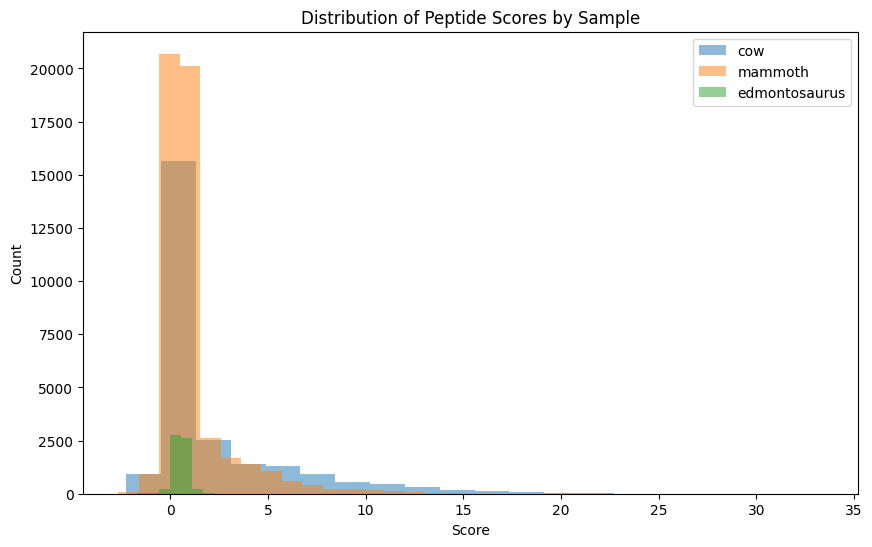

In [9]:
# Example: Create a histogram of peptide scores by sample
plt.figure(figsize=(10, 6))
for sample in df['actual_sample'].unique():
  sample_data = df[df['actual_sample'] == sample]
  plt.hist(sample_data['score'], alpha=0.5, label=sample, bins=20)
plt.legend()
plt.title('Distribution of Peptide Scores by Sample')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()
